In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)

In [2]:
TEST_SPLIT_SIZE = 0.3
RANDOM_STATE = 30

## Data and Preprocessing

In [3]:
%pip install ucimlrepo

from IPython.display import clear_output
clear_output()

from ucimlrepo import fetch_ucirepo

In [4]:
df = fetch_ucirepo(id=350)

X = df.data.features 
y = df.data.targets

print(X.shape)
X.head()

(30000, 23)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [5]:
mapping = df.variables.set_index("name")["description"]

X = X.rename(columns=mapping)
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [6]:
y = y["Y"]
y.shape, y.unique()

((30000,), array([1, 0]))

In [7]:
NUMERIC_COLS = X.select_dtypes(include='number').columns
CATEGORICAL_COLS = X.select_dtypes(include='category').columns # No categorical columns in this dataset

NUMERIC_COLS, CATEGORICAL_COLS

(Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
       dtype='object'),
 Index([], dtype='object'))

In [8]:
X.describe().round(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,...,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50
std,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,...,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47
min,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,...,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75
50%,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,...,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,...,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,...,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Helper function to evaluate model performance

def eval(model, X, y):
    predicted = model.predict(X)
    accuracy = accuracy_score(y, predicted)
    report = classification_report(y, predicted)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.4f}")
    print("Classification Report:")
    print(report)

# Models

In [12]:
models = {}

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg.fit(X_train, y_train)

models['Logistic Regression'] = log_reg

In [15]:
eval(log_reg, X_test, y_test)

Accuracy: 0.8133
AUC: 0.7319
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      7009
           1       0.76      0.23      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.79      0.60      0.62      9000
weighted avg       0.80      0.81      0.77      9000



In [16]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds Ratio': np.exp(log_reg.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

In [17]:
print("\nTop 10 Most Important Features:")
print(coef_df.head(10).to_string(index=False))


Top 10 Most Important Features:
  Feature  Coefficient  Odds Ratio
    PAY_0     0.621665    1.862026
BILL_AMT1    -0.383514    0.681462
 PAY_AMT1    -0.206758    0.813216
 PAY_AMT2    -0.201951    0.817135
BILL_AMT2     0.143274    1.154046
    PAY_2     0.112997    1.119629
BILL_AMT5     0.106507    1.112386
 PAY_AMT4    -0.106334    0.899125
 MARRIAGE    -0.096288    0.908203
LIMIT_BAL    -0.094656    0.909686


In [18]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
cv_scores_log = []

In [19]:
print("\nCross-Validation Results for Different C Values:")
print(f"{'C Value':<12} {'Mean AUC':<12} {'Std AUC':<12}")
print("-" * 36)

for C in C_values:
    lr = LogisticRegression(C=C, random_state=RANDOM_STATE, max_iter=1000)
    scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
    cv_scores_log.append(scores.mean())
    print(f"{C:<12} {scores.mean():.4f}      {scores.std():.4f}")

best_C = C_values[np.argmax(cv_scores_log)]
print(f"\nBest C value: {best_C}")


Cross-Validation Results for Different C Values:
C Value      Mean AUC     Std AUC     
------------------------------------
0.001        0.7131      0.0066
0.01         0.7176      0.0065
0.1          0.7177      0.0065
1            0.7177      0.0065
10           0.7177      0.0065
100          0.7177      0.0065

Best C value: 0.1


In [20]:
log_reg_tuned = LogisticRegression(C=best_C, random_state=RANDOM_STATE, max_iter=1000)
log_reg_tuned.fit(X_train, y_train)
y_pred_log_tuned = log_reg_tuned.predict(X_test)
y_prob_log_tuned = log_reg_tuned.predict_proba(X_test)[:, 1]

In [69]:
eval(log_reg_tuned, X_test, y_test)

Accuracy: 0.8132
AUC: 0.7317
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      7009
           1       0.76      0.23      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.79      0.60      0.62      9000
weighted avg       0.80      0.81      0.77      9000



In [21]:
print(f"\nTuned Logistic Regression Performance (C={best_C}):")
print(f"    - Accuracy: {accuracy_score(y_test, y_pred_log_tuned):.4f}")
print(f"    - ROC-AUC: {roc_auc_score(y_test, y_prob_log_tuned):.4f}")


Tuned Logistic Regression Performance (C=0.1):
    - Accuracy: 0.8133
    - ROC-AUC: 0.7317


## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
'''
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")
'''

'\nparam_grid = {\n    \'n_estimators\': [10, 50, 100, 200],\n    \'max_depth\': [5, 10, 15, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\nrf = RandomForestClassifier(random_state=RANDOM_STATE)\n\n# Grid Search with cross-validation\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    cv=5,\n    scoring=\'accuracy\',\n    n_jobs=-1,  # Use all processors\n    verbose=2\n)\n\n# Fit the grid search\ngrid_search.fit(X_train, y_train)\n\n# Results\nprint(f"Best Parameters: {grid_search.best_params_}")\nprint(f"Best CV Score: {grid_search.best_score_:.4f}")\nprint(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")\n'

In [24]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=RANDOM_STATE
    )
rf.fit(X_train, y_train)

models['Random Forest'] = rf

In [25]:
eval(rf, X_test, y_test)

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

feat_importance.head(10)

Accuracy: 0.8232
AUC: 0.7839
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7009
           1       0.70      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.77      0.66      0.68      9000
weighted avg       0.81      0.82      0.80      9000



,Feature,Importance
5,PAY_0,0.241157
6,PAY_2,0.106139
7,PAY_3,0.054423
9,PAY_5,0.049966
8,PAY_4,0.046821
17,PAY_AMT1,0.045308
11,BILL_AMT1,0.038096
0,LIMIT_BAL,0.037839
12,BILL_AMT2,0.035061
18,PAY_AMT2,0.034932


## KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
param_grid = {
    'n_neighbors': [1, 5, 10, 20, 50]
}

knn = KNeighborsClassifier()

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_neighbors': 20}
Best CV Score: 0.8076
Test Score: 0.8148


In [28]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

models['K-Nearest Neighbors'] = knn

In [29]:
eval(knn, X_test, y_test)

Accuracy: 0.7943
AUC: 0.7097
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7009
           1       0.56      0.35      0.43      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.64      0.65      9000
weighted avg       0.77      0.79      0.78      9000



## SVM

In [64]:
# SVM

In [30]:
from sklearn.svm import SVC

svm_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=RANDOM_STATE
)

svm_full.fit(X_train, y_train)

eval(svm_full, X_test, y_test)

models['SVM'] = svm_full

Accuracy: 0.8242
AUC: 0.7335
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      7009
           1       0.72      0.34      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.78      0.65      0.68      9000
weighted avg       0.81      0.82      0.80      9000



In [31]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']
}

svm = SVC(probability=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=6,
    verbose=2
)

grid_search.fit(X_train, y_train)

svm_tuned_full = grid_search.best_estimator_

eval(svm_tuned_full, X_test, y_test)

models['Tuned SVM'] = svm_tuned_full

[CV] END ......................................n_neighbors=1; total time=   0.8s
[CV] END .....................................n_neighbors=10; total time=   0.8s
[CV] END ......................................n_neighbors=1; total time=   0.8s
[CV] END .....................................n_neighbors=10; total time=   0.8s
[CV] END ......................................n_neighbors=1; total time=   1.1s
[CV] END .....................................n_neighbors=50; total time=   1.0s
[CV] END .....................................n_neighbors=10; total time=   0.8s
[CV] END .....................................n_neighbors=20; total time=   0.8s
[CV] END .....................................n_neighbors=10; total time=   0.8s
[CV] END .....................................n_neighbors=50; total time=   0.8s
[CV] END ......................................n_neighbors=5; total time=   0.8s
[CV] END .....................................n_neighbors=50; total time=   0.8s
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...C=0.1, class_weight=None, gamma=auto, kernel=rbf; total time=  36.9s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  34.3s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  53.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  53.5s
[CV] END ....C=1, class_weight=None, gamma=scale, kernel=rbf; total time=  38.7s
[CV] END ...C=0.1, class_weight=None, gamma=auto, kernel=rbf; total time=  38.2s
[CV] END ....C=0.1, class_weight=None, gamma=0.1, kernel=rbf; total time=  41.0s
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=rbf; total time=  56.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=  57.0s
[CV] END .....C=1, class_weight=None, gamma=auto, kernel=rbf; total time=  40.4s
[CV] END ...C=0.1, class_weight=None, gamma=auto, kernel=rbf; total time=  37.2s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  35.0s
[CV] END C=0.1, class_we

In [32]:
print("===== BASELINE SVM =====")
preds_full = svm_full.predict(X_test)
probs_full = svm_full.predict_proba(X_test)[:, 1]
print("Accuracy:", round(accuracy_score(y_test, preds_full), 4))
print("AUC:", round(roc_auc_score(y_test, probs_full), 4))
print("Classification Report:")
print(classification_report(y_test, preds_full))

print("Support vectors per class (Baseline):", svm_full.n_support_)
print("Total support vectors (Baseline):", svm_full.support_vectors_.shape[0])


print("\n===== TUNED SVM =====")
preds_tuned = svm_tuned_full.predict(X_test)
probs_tuned = svm_tuned_full.predict_proba(X_test)[:, 1]
print("Accuracy:", round(accuracy_score(y_test, preds_tuned), 4))
print("AUC:", round(roc_auc_score(y_test, probs_tuned), 4))
print("Classification Report:")
print(classification_report(y_test, preds_tuned))

print("Support vectors per class (Tuned):", svm_tuned_full.n_support_)
print("Total support vectors (Tuned):", svm_tuned_full.support_vectors_.shape[0])


print("\nBest Params:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

===== BASELINE SVM =====
Accuracy: 0.8242
AUC: 0.7335
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      7009
           1       0.72      0.34      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.78      0.65      0.68      9000
weighted avg       0.81      0.82      0.80      9000

Support vectors per class (Baseline): [5207 4099]
Total support vectors (Baseline): 9306

===== TUNED SVM =====
Accuracy: 0.7833
AUC: 0.7655
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7009
           1       0.51      0.58      0.54      1991

    accuracy                           0.78      9000
   macro avg       0.69      0.71      0.70      9000
weighted avg       0.79      0.78      0.79      9000

Support vectors per class (Tuned): [10602  3137]
Total support vectors (Tuned): 13739

Best Params: {'C':

# Results

In [33]:
models.keys()

dict_keys(['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors', 'SVM', 'Tuned SVM'])

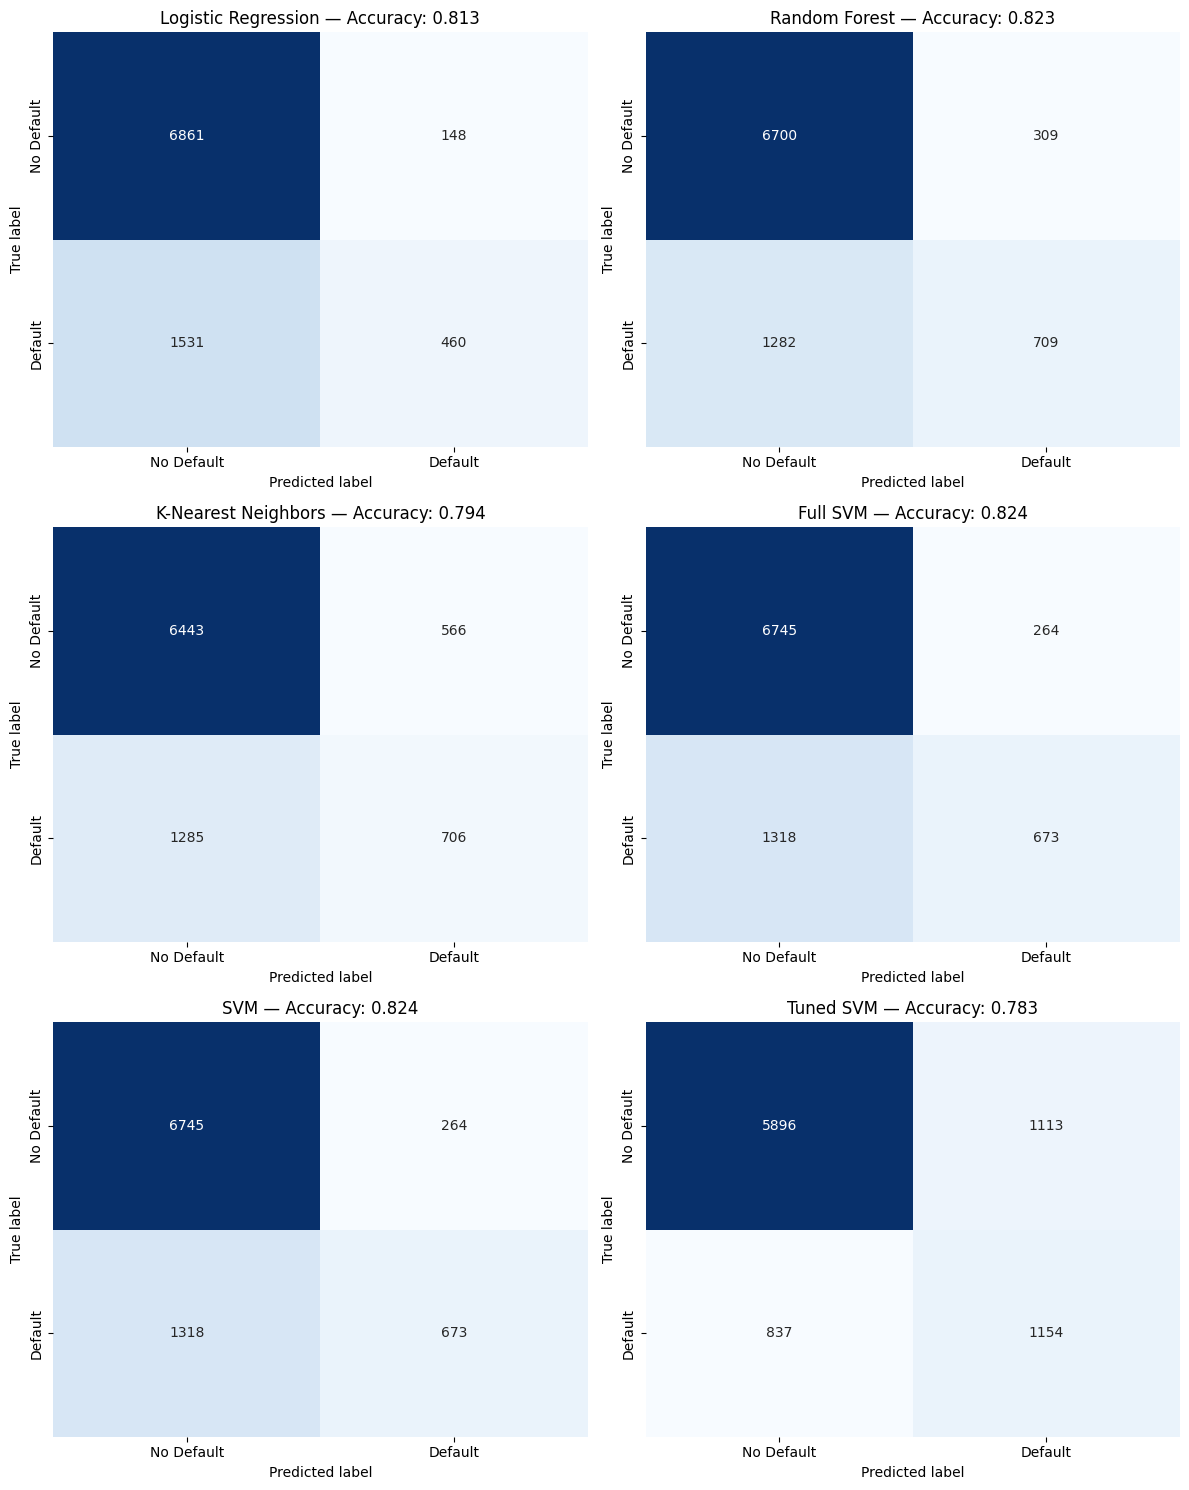

In [68]:
import numpy as np

n_models = len(models)
cols = 2
rows = int(np.ceil(n_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    # heatmap of raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f"{name} — Accuracy: {acc:.3f}")

# Turn off any unused axes
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

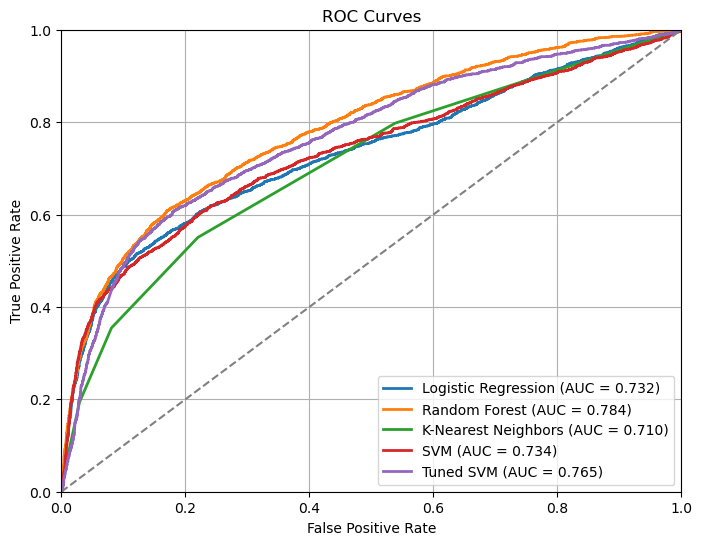

In [35]:
# Plot overlayed ROC curves for all trained models with diagonal dashed line
fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    # get probabilities for the positive class
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        # fallback to decision_function if predict_proba not available
        probs = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot diagonal (random guess) line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

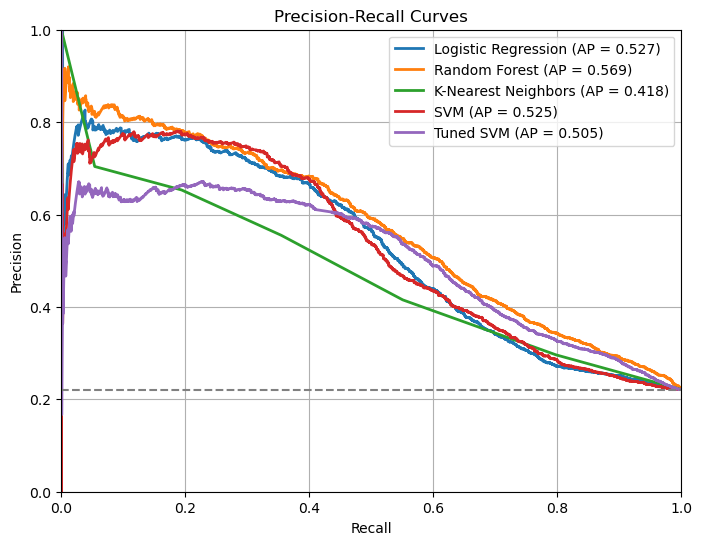

[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=  56.5s
[CV] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  55.0s
[CV] END ..C=100, class_weight=None, gamma=scale, kernel=rbf; total time= 1.6min
[CV] END ...C=100, class_weight=None, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END C=100, class_weight=balanced, gamma=scale, kernel=rbf; total time= 1.5min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  55.9s
[CV] END ..C=100, class_weight=None, gamma=scale, kernel=rbf; total time= 1.6min
[CV] END ...C=100, class_weight=None, gamma=0.01, kernel=rbf; total time= 1.3min
[CV] END C=100, class_weight=balanced, gamma=scale, kernel=rbf; total time= 1.5min
[CV] END C=100, class_weight=balanced, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=  54.1s
[CV] END ....C=10, cl

In [36]:
# Plot overlayed Precision-Recall curves for all trained models
fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    # get probabilities for the positive class
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        # fallback to decision_function if predict_proba not available
        probs = model.decision_function(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    ax.plot(recall, precision, lw=2, label=f"{name} (AP = {ap:.3f})")

# Plot no-skill baseline
no_skill = (y_test == 1).sum() / len(y_test)
ax.axhline(y=no_skill, linestyle="--", color="gray")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves")
ax.legend(loc="best")
ax.grid(True)
plt.show()